In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import rubin_sim.maf as maf

In [145]:
families = maf.get_family_descriptions('runs_v2.2.json')
family_list = families.index.values

summary_source = 'summary_2022_11_13.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
franken_summaries = maf.get_metric_summaries(summary_source='franken_summary.csv')

remap_columns = False # do this if there's a mix
# Set SN metric names back to previous versions
exccols = [m for m in franken_summaries if "DDF excluded" in m and 'NSN' in m]
oldexcols = [m.replace(' DDF excluded', ' ') for m in exccols]
onlycols = [m for m in franken_summaries if ", only DDF observations" in m and "NSN" in m]
oldonlycols = [m.replace(', only DDF observations', '') for m in onlycols]
if remap_columns: 
    d = franken_summaries.copy()
    for ec, uc in zip(exccols, oldexcols):
        rii = np.where(np.isnan(franken_summaries[uc]))
        d[uc].iloc[rii] = franken_summaries[ec].iloc[rii]
    d.drop(exccols, axis=1, inplace=True)
    for ec, uc in zip(onlycols, oldonlycols):
        rii = np.where(np.isnan(franken_summaries[uc]))
        d[uc].iloc[rii] = franken_summaries[ec].iloc[rii]
    d.drop(onlycols, axis=1, inplace=True)
    franken_summaries = d
else: # do this is just a swap
    mapper = dict(zip(exccols, oldexcols))
    franken_summaries.rename(mapper, axis=1, inplace=True)
    mapper = dict(zip(onlycols, oldonlycols))
    franken_summaries.rename(mapper, axis=1, inplace=True)
    
metrics_source = 'metric_sets.json'
metric_sets = maf.get_metric_sets(metrics_source)

# list the metric sets
msets = list(metric_sets.groupby('metric set').first().index)

In [146]:
len(franken_summaries.index)

15

In [147]:
# drop_metrics = [m for m in franken_summaries if 'Completeness@Time' in m]
newmetrics = list(metric_sets.loc['SSO discovery']['metric'].values)
newmetrics
oldmetrics = []
for n in newmetrics:
    hval = n.split("H<=")[-1]
    objtype = n.split('loss ')[-1].split(' H')[0]
    kk = f"CumulativeCompleteness H <= {hval}"
    kk2 = f"{objtype} 3 pairs in 15 nights detection loss"
    oldmetrics += [m for m in franken_summaries if kk in m and kk2 in m]
mapper = dict(zip(oldmetrics, newmetrics))
franken_summaries.rename(mapper, axis=1, inplace=True)
newmetrics = list(metric_sets.loc['SSO lightcurve inversion']['metric'].values)
oldmetrics = []
for n in newmetrics:
    hval = n.split("H=")[-1]
    objtype = n.split('Inversion ')[-1].split(' H')[0]
    oldmetrics += [m for m in franken_summaries if f"FractionPop Lightcurve Inversion H = {hval}" in m
                  and objtype in m]
mapper = dict(zip(oldmetrics, newmetrics))
franken_summaries.rename(mapper, axis=1, inplace=True)

In [148]:
these_runs = list(franken_summaries.index.values)
weights = [float(r.split('repeat')[-1].split('_')[0]) for r in these_runs if
           not r.startswith('baseline') and 'fp' not in r]
weights.sort()
runorder = []
for w in weights:
    kk = f'repeat{w}'
    runorder += [r for r in these_runs if kk in r and 'fp' not in r]
for w in weights:
    kk = f'repeat{w}'
    runorder += [r for r in these_runs if kk in r and 'fp' in r]
runorder
these_runs = runorder
runorder

['franken_supress_repeat0.0_v2.99_10yrs',
 'franken_supress_repeat1.0_v2.99_10yrs',
 'franken_supress_repeat2.0_v2.99_10yrs',
 'franken_supress_repeat10.0_v2.99_10yrs',
 'franken_supress_repeat20.0_v2.99_10yrs',
 'franken_supress_repeat50.0_v2.99_10yrs',
 'franken_supress_repeat100.0_v2.99_10yrs',
 'franken_supress_fp_repeat0.0_v2.99_10yrs',
 'franken_supress_fp_repeat1.0_v2.99_10yrs',
 'franken_supress_fp_repeat2.0_v2.99_10yrs',
 'franken_supress_fp_repeat10.0_v2.99_10yrs',
 'franken_supress_fp_repeat20.0_v2.99_10yrs',
 'franken_supress_fp_repeat50.0_v2.99_10yrs',
 'franken_supress_fp_repeat100.0_v2.99_10yrs']

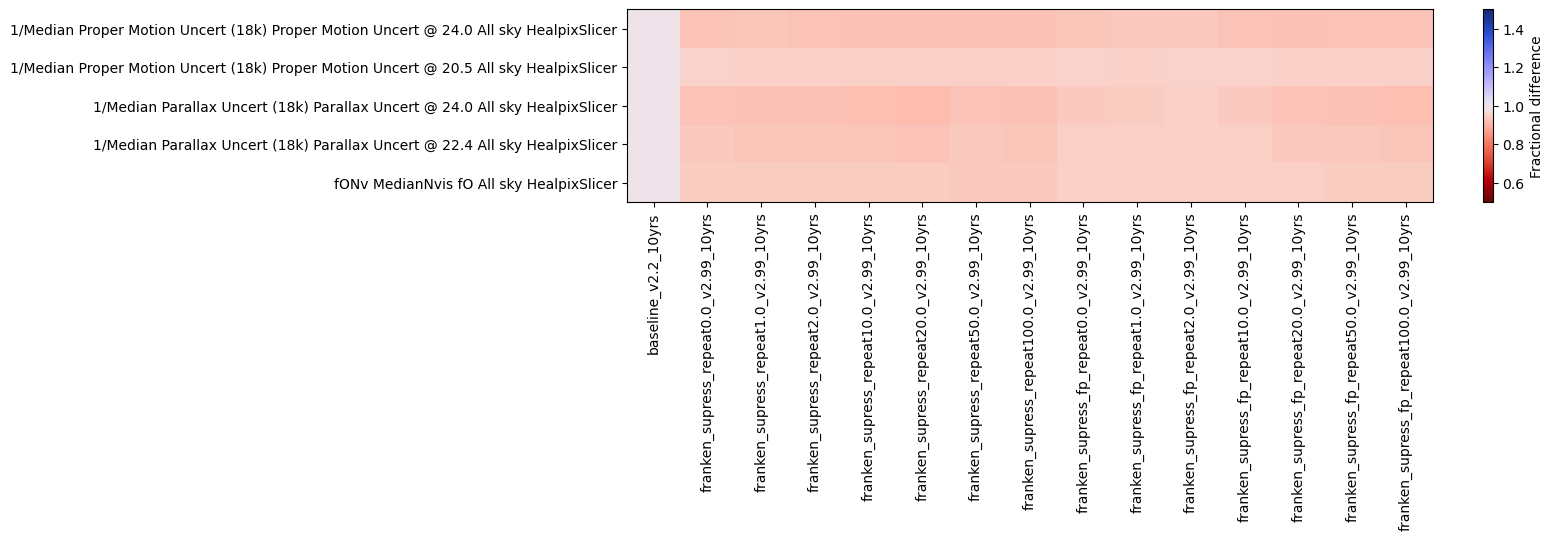

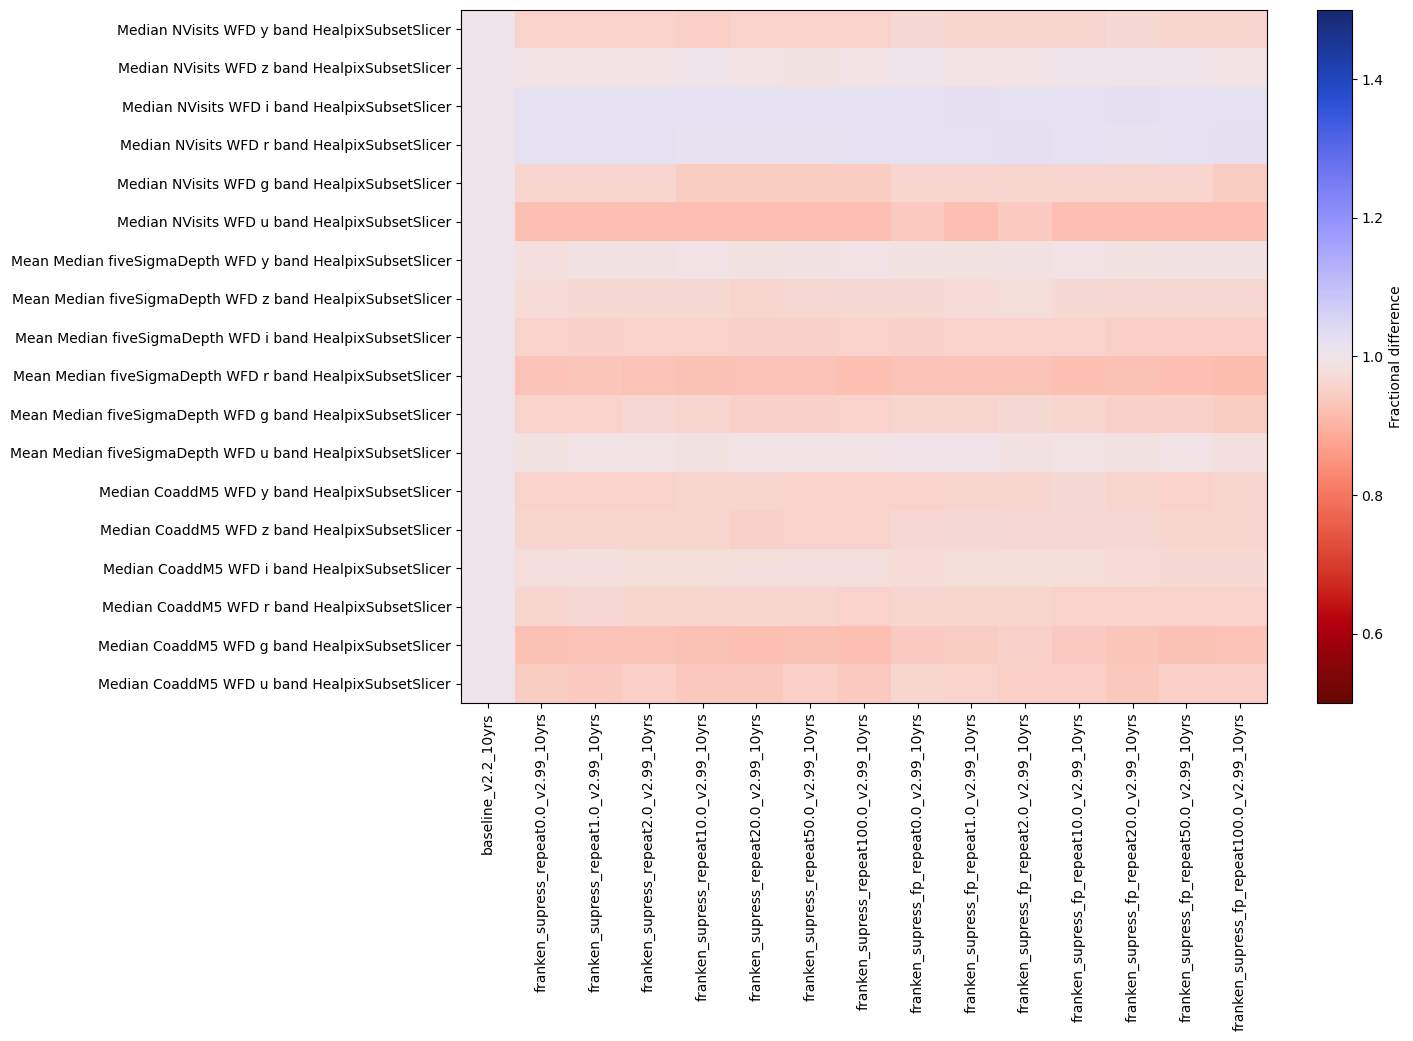

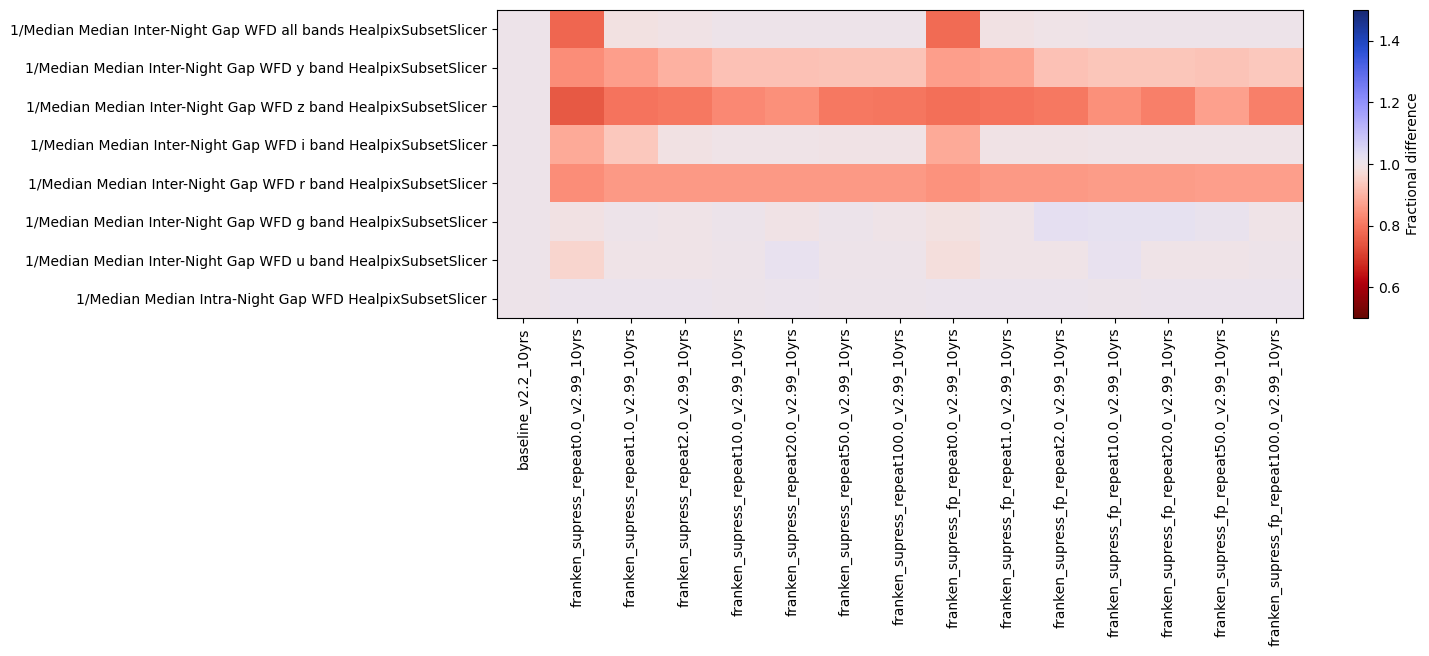

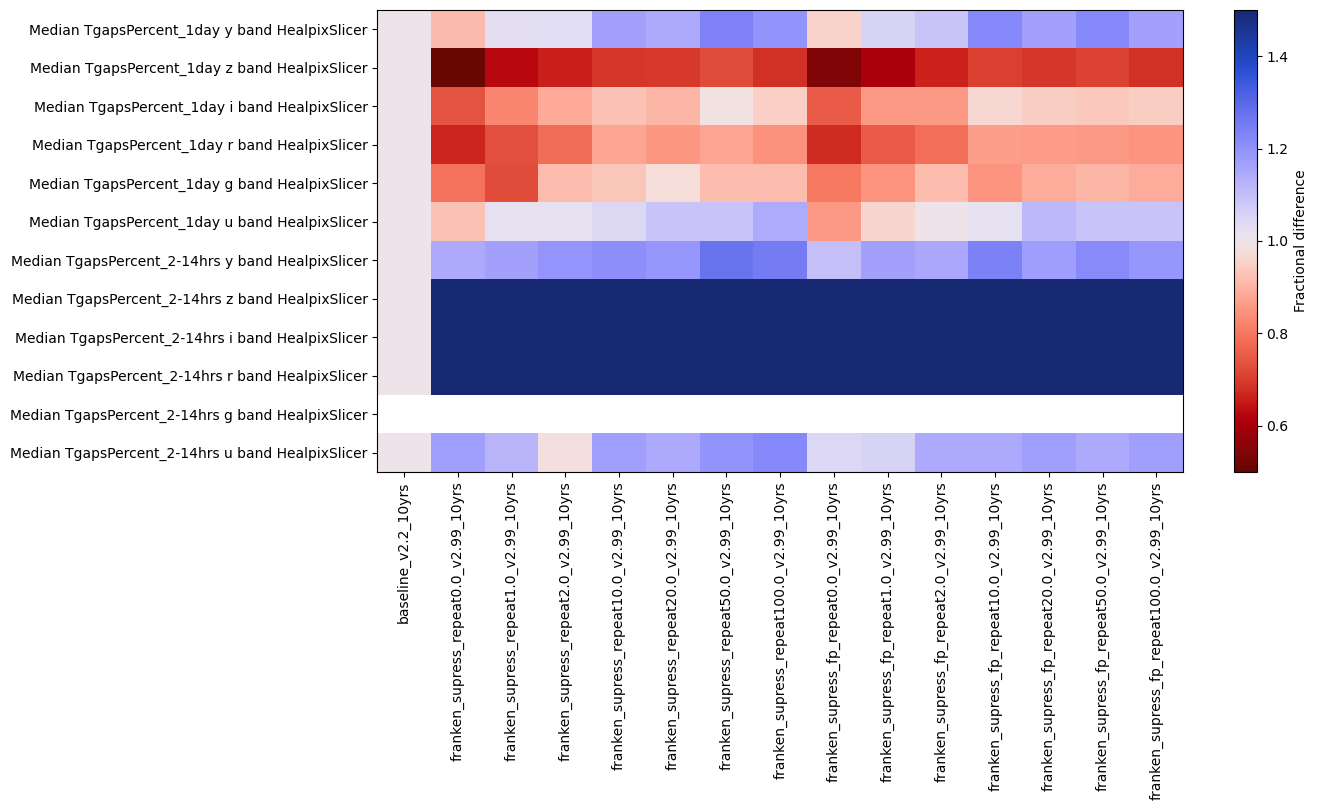

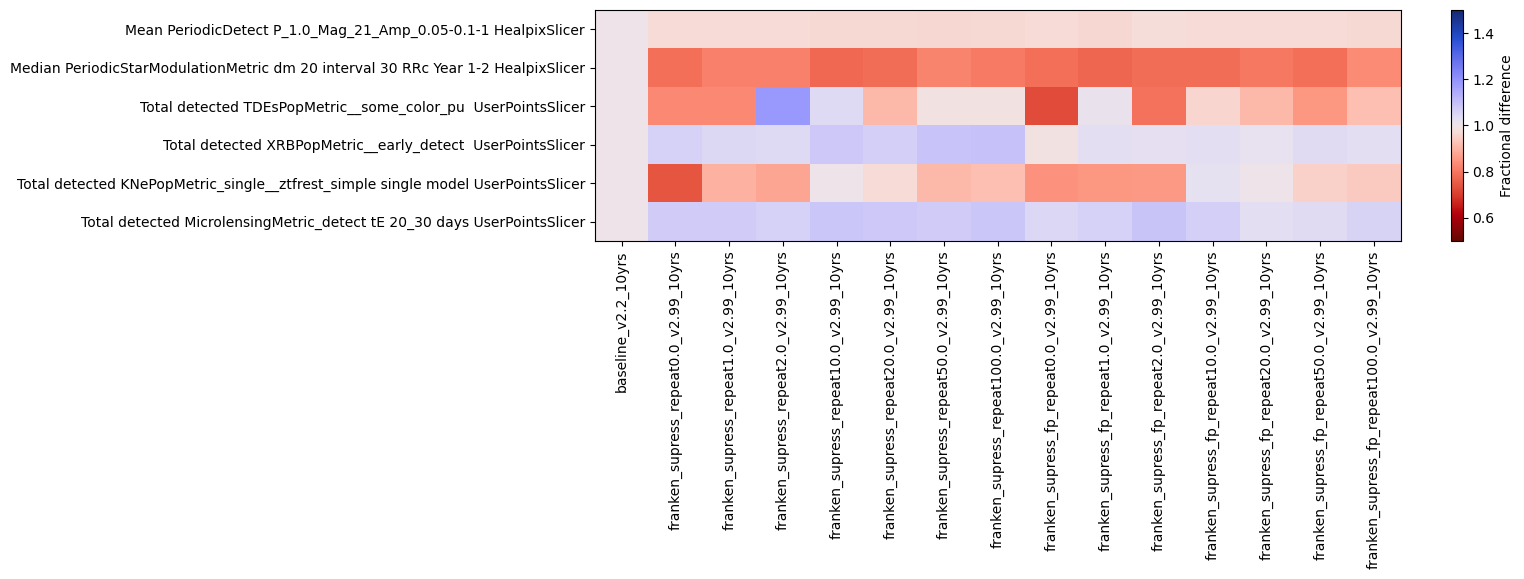

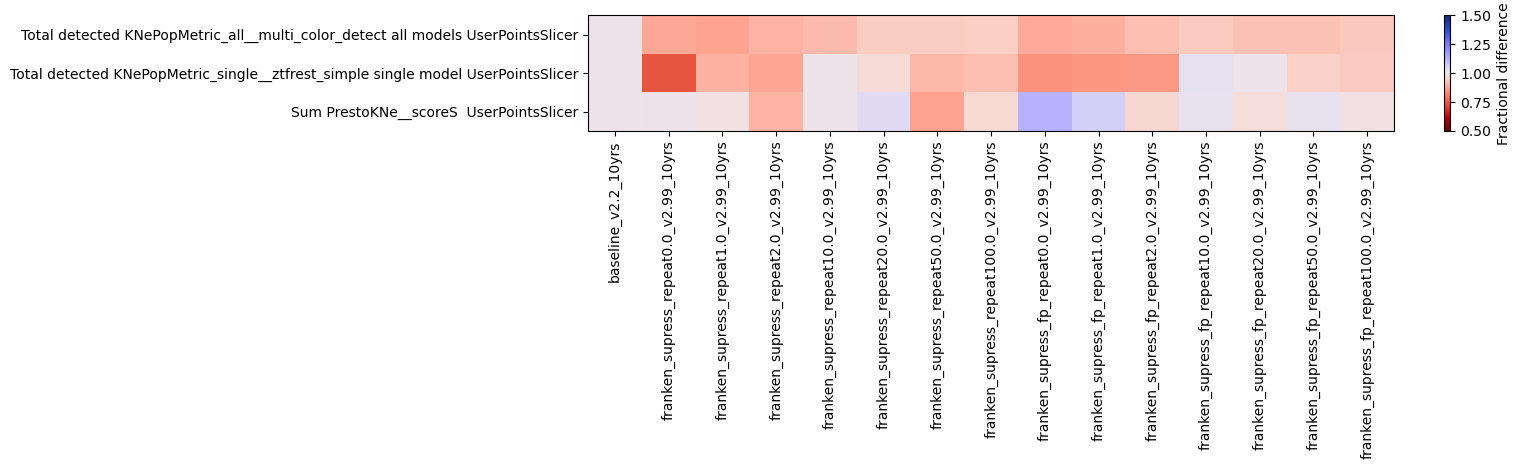

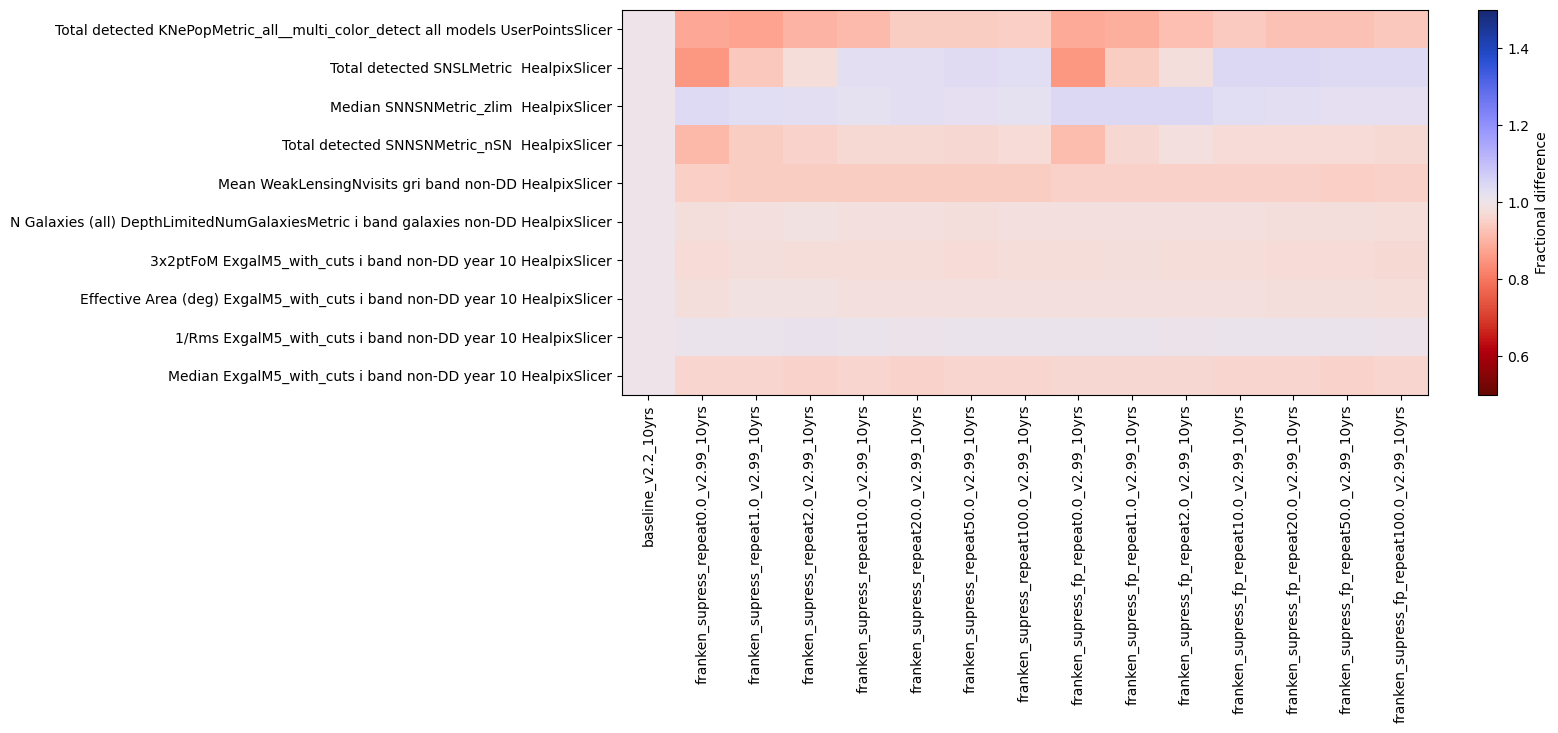

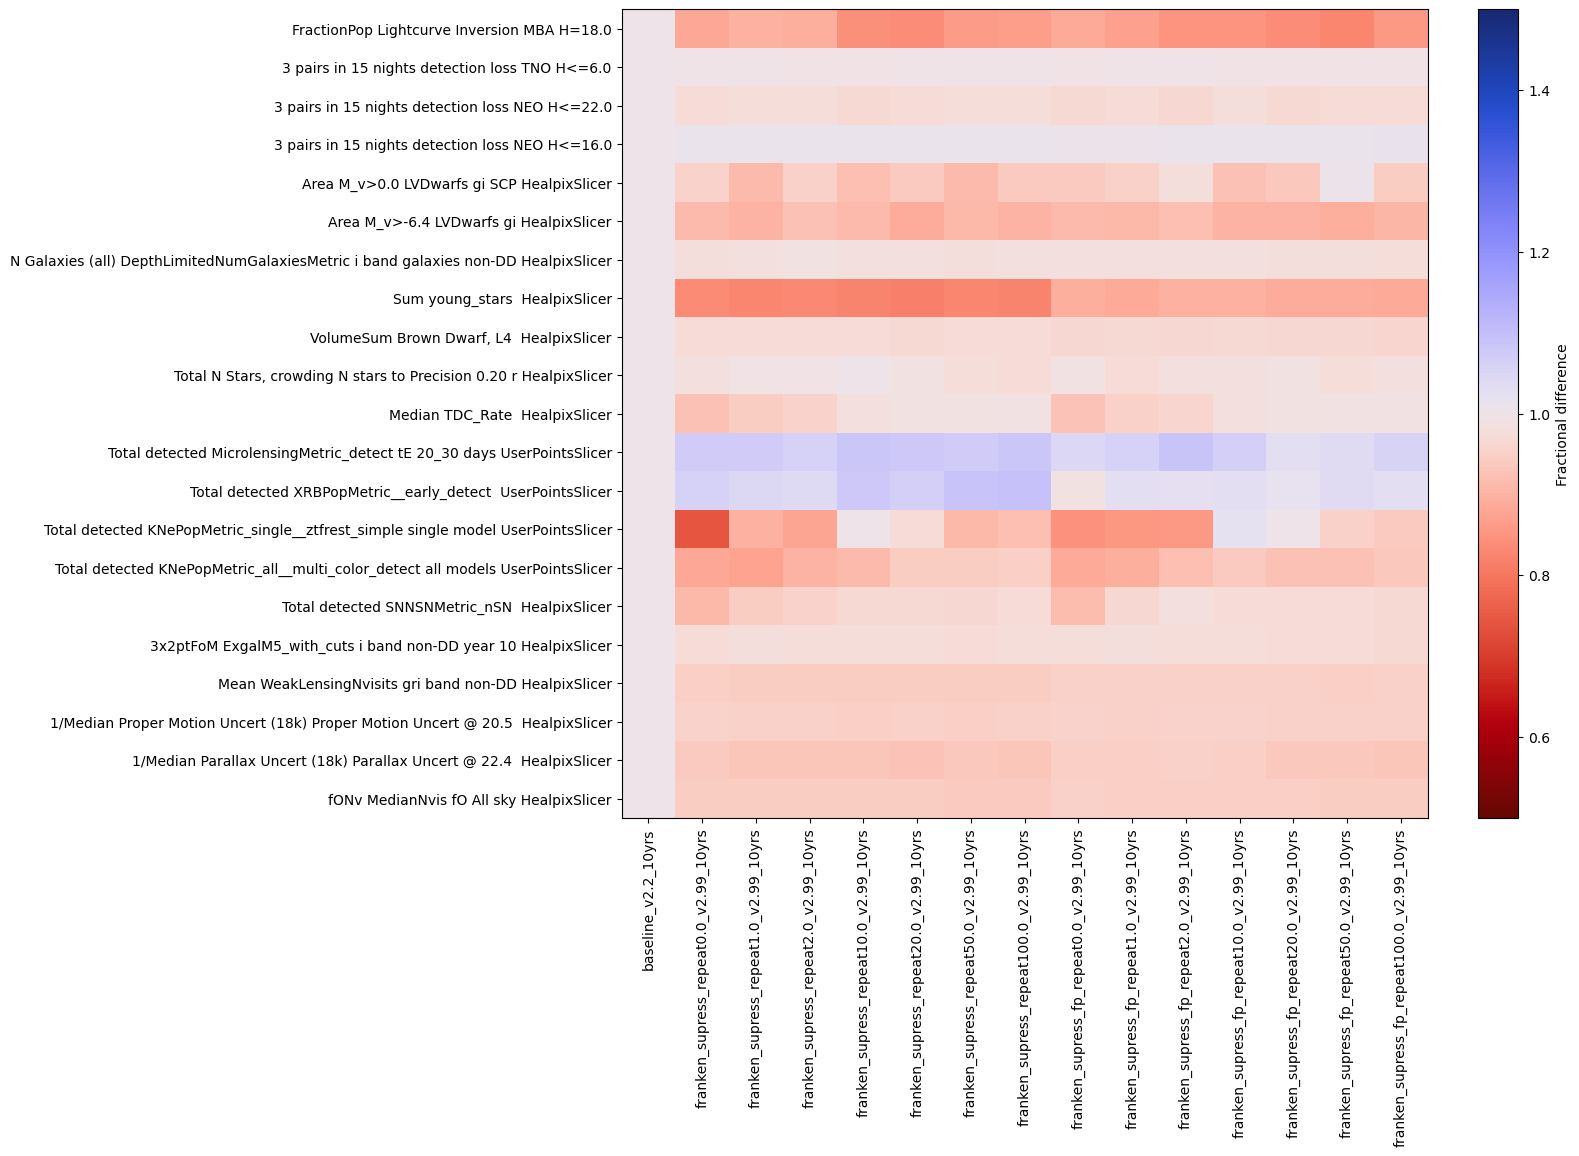

In [149]:
baseline_run = 'baseline_v2.2_10yrs'
these_runs = [baseline_run] + these_runs

for k in ['SRD', 'WFD Depths', 'cadence', 'TVS Tgaps', 'TVS short', 'TVS KNe short',
      'DESC WFD', 'SCOC']:
    msub = metric_sets.loc[k]
    fig, ax = maf.plot_run_metric_mesh(franken_summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=1)
    fig.set_figwidth(13)
    fig.set_figheight(len(msub)*.5)

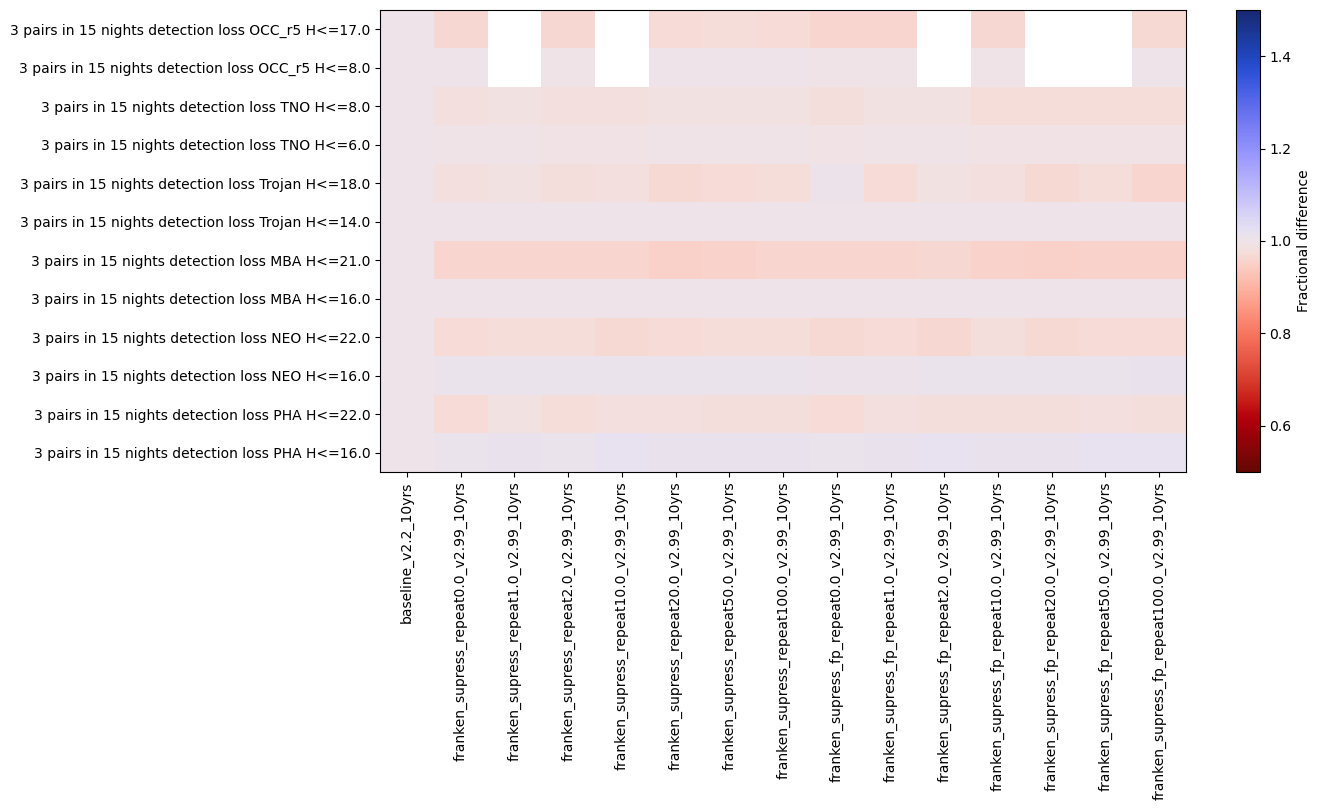

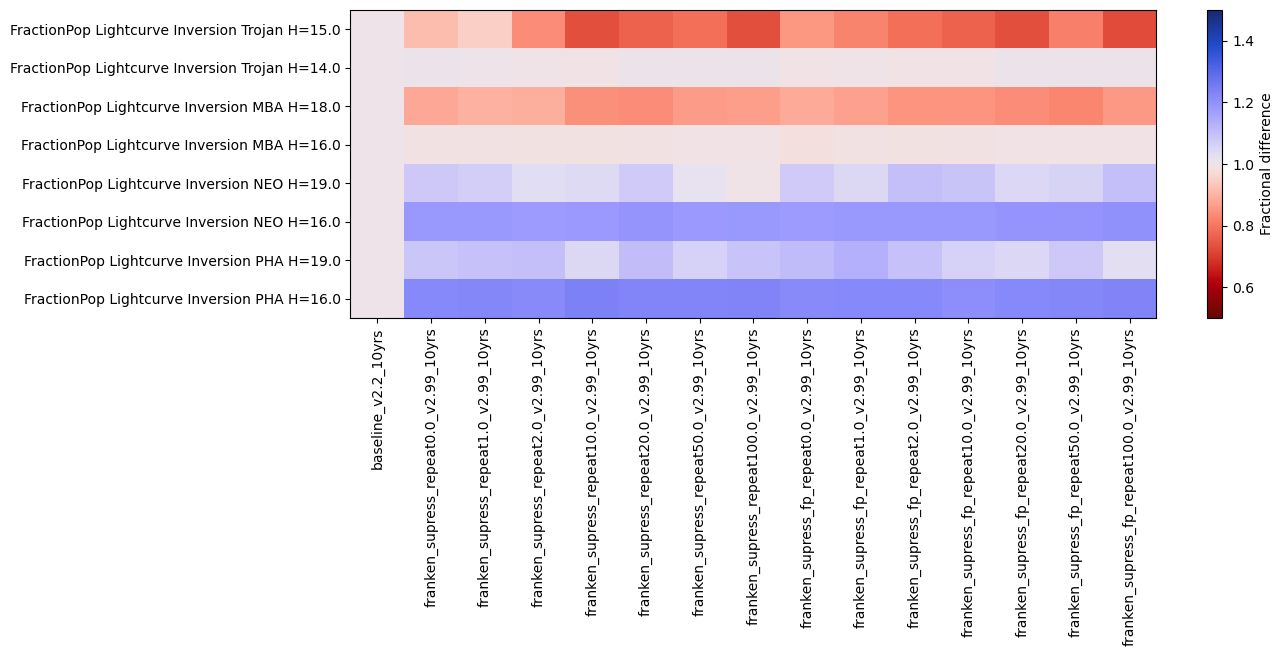

In [150]:
for k in ['SSO discovery']:
    msub = metric_sets.loc[k]
    # the OCC_r20 metrics are missing
    msub = msub[0:12]
    fig, ax = maf.plot_run_metric_mesh(franken_summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=1)
    fig.set_figwidth(13)
    fig.set_figheight(len(msub)*.5)
    
for k in ['SSO lightcurve inversion']:
    msub = metric_sets.loc[k]
    # the OCC_r20 metrics are missing
    msub = msub[0:12]
    fig, ax = maf.plot_run_metric_mesh(franken_summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=1)
    fig.set_figwidth(13)
    fig.set_figheight(len(msub)*.5)

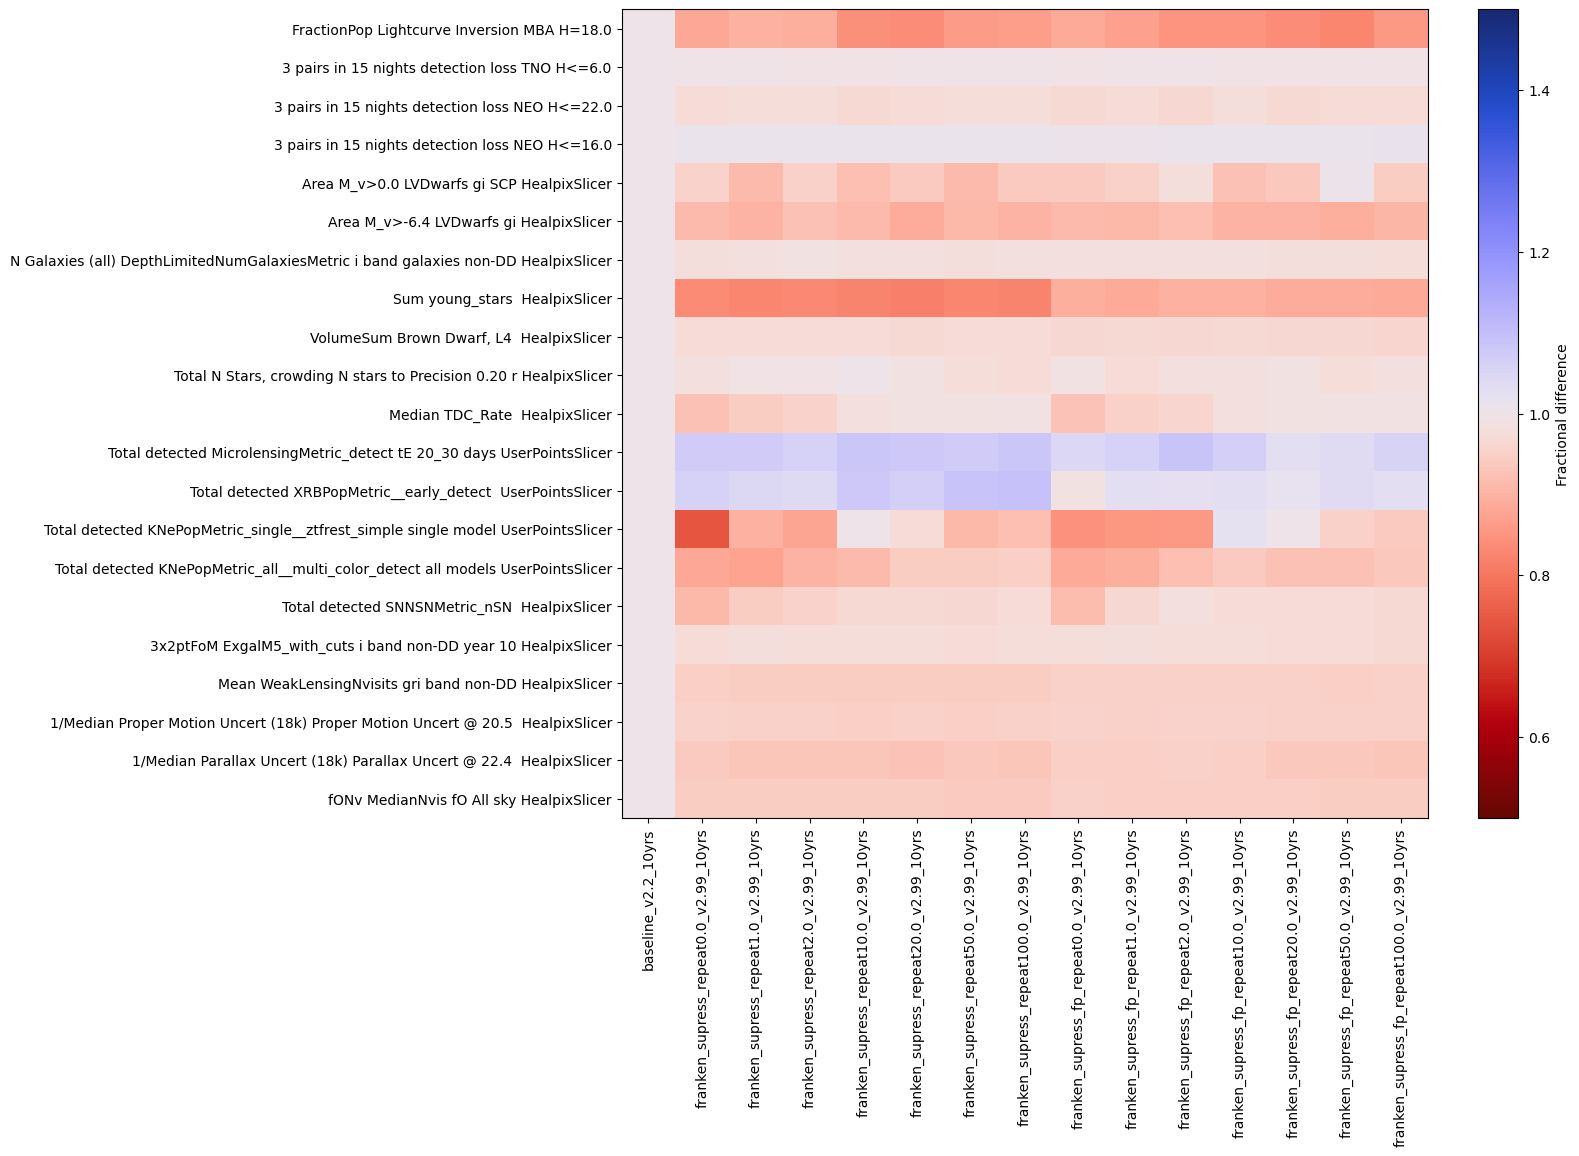

In [151]:
for k in ['SCOC']:
    msub = metric_sets.loc[k]
    fig, ax = maf.plot_run_metric_mesh(franken_summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=1)
    fig.set_figwidth(13)
    fig.set_figheight(len(msub)*.5)

In [155]:
metrics = ['Area (sq deg) RapidRevisits WFD HealpixSubsetSlicer',
           'Median slewTime All visits', 'Mean slewTime All visits']
franken_summaries.loc[these_runs, metrics]

metric,Area (sq deg) RapidRevisits WFD HealpixSubsetSlicer,Median slewTime All visits,Mean slewTime All visits
run,,,
baseline_v2.2_10yrs,41251.101165,4.859362,7.935578
franken_supress_repeat0.0_v2.99_10yrs,41248.750045,4.822346,7.898677
franken_supress_repeat1.0_v2.99_10yrs,41244.535830,4.824059,7.963297
franken_supress_repeat2.0_v2.99_10yrs,41252.961249,4.825150,7.985150
franken_supress_repeat10.0_v2.99_10yrs,41240.228199,4.821588,7.989218
franken_supress_repeat20.0_v2.99_10yrs,41235.921612,4.820945,7.985977
franken_supress_repeat50.0_v2.99_10yrs,41216.440896,4.821453,8.003928
franken_supress_repeat100.0_v2.99_10yrs,41229.227851,4.821122,7.996636
franken_supress_fp_repeat0.0_v2.99_10yrs,41246.813267,4.821506,7.897038


In [156]:
pd.DataFrame(franken_summaries.loc[these_runs, 'Nvisits DDF']/franken_summaries.loc[these_runs, 'Nvisits All visits'],
        columns=['Fraction DDF']).round(3)

,Fraction DDF
run,
baseline_v2.2_10yrs,0.050
franken_supress_repeat0.0_v2.99_10yrs,0.066
franken_supress_repeat1.0_v2.99_10yrs,0.066
franken_supress_repeat2.0_v2.99_10yrs,0.066
franken_supress_repeat10.0_v2.99_10yrs,0.066
franken_supress_repeat20.0_v2.99_10yrs,0.066
franken_supress_repeat50.0_v2.99_10yrs,0.066
franken_supress_repeat100.0_v2.99_10yrs,0.066
franken_supress_fp_repeat0.0_v2.99_10yrs,0.066


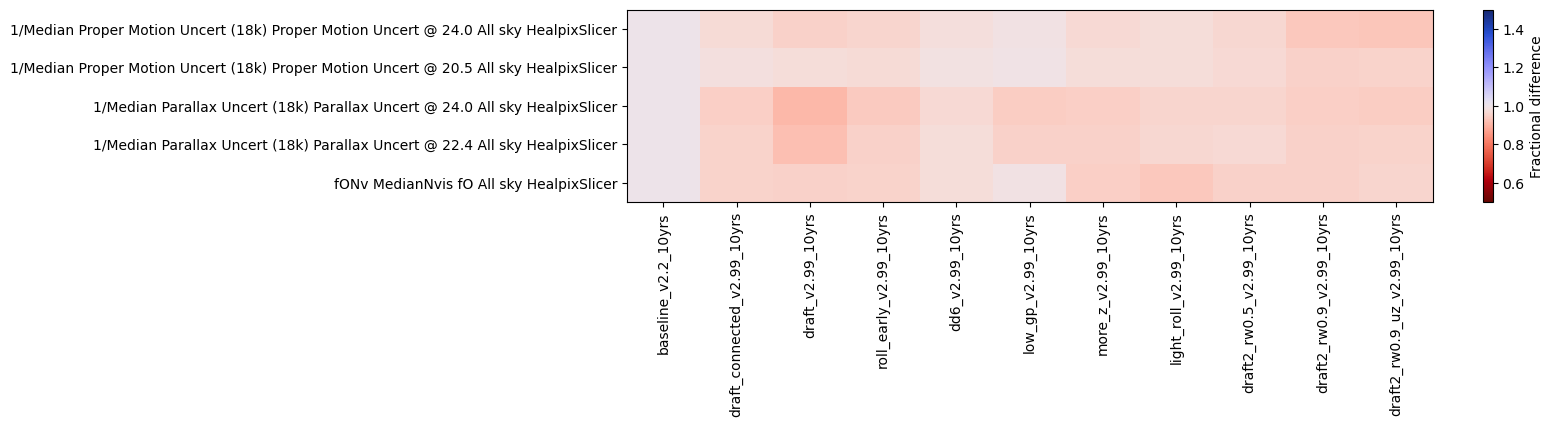

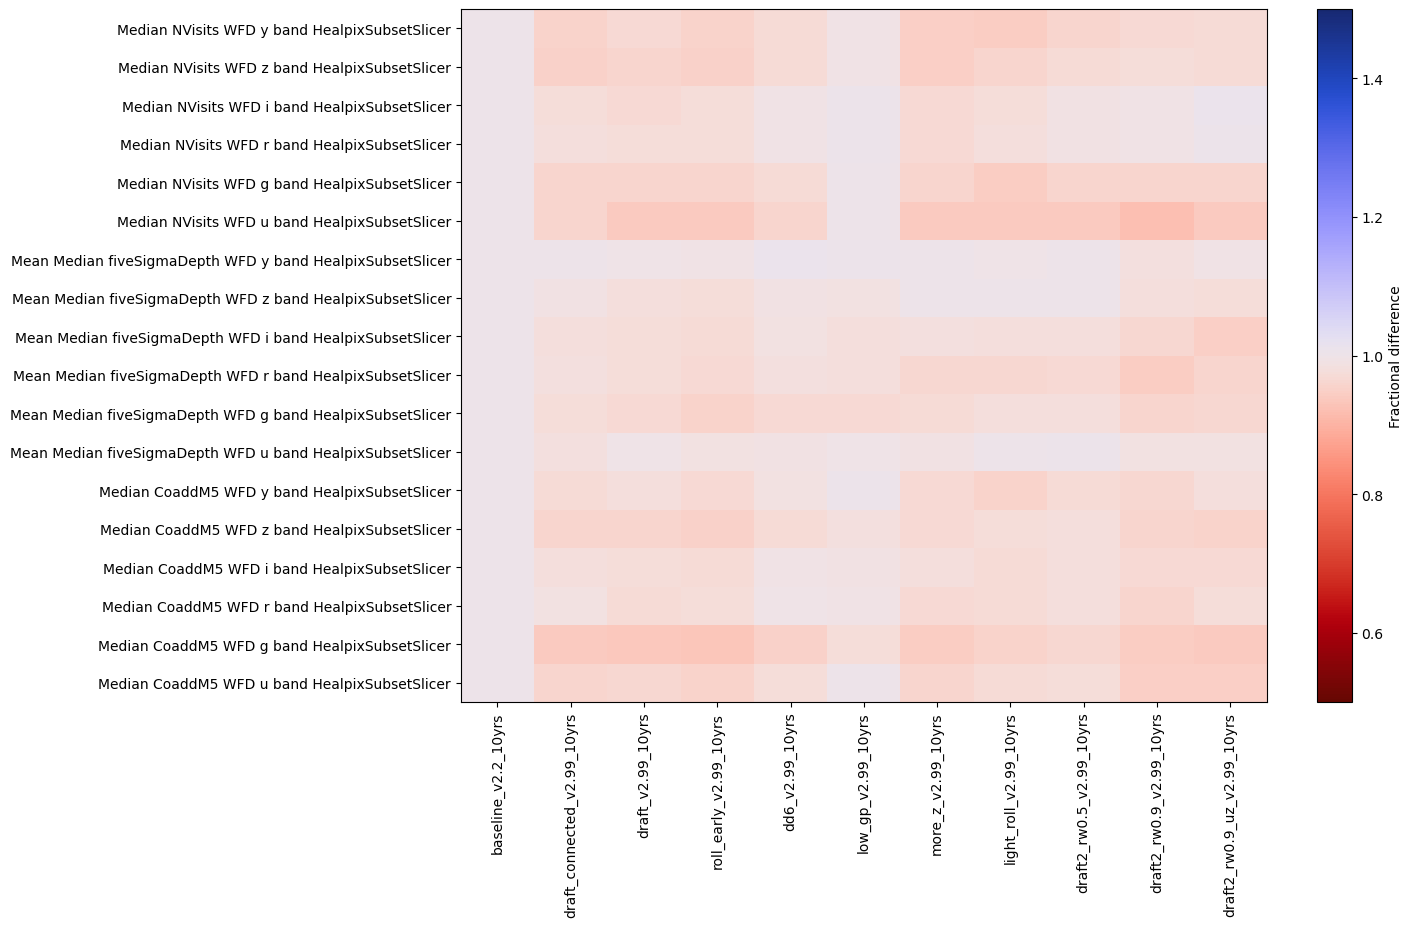

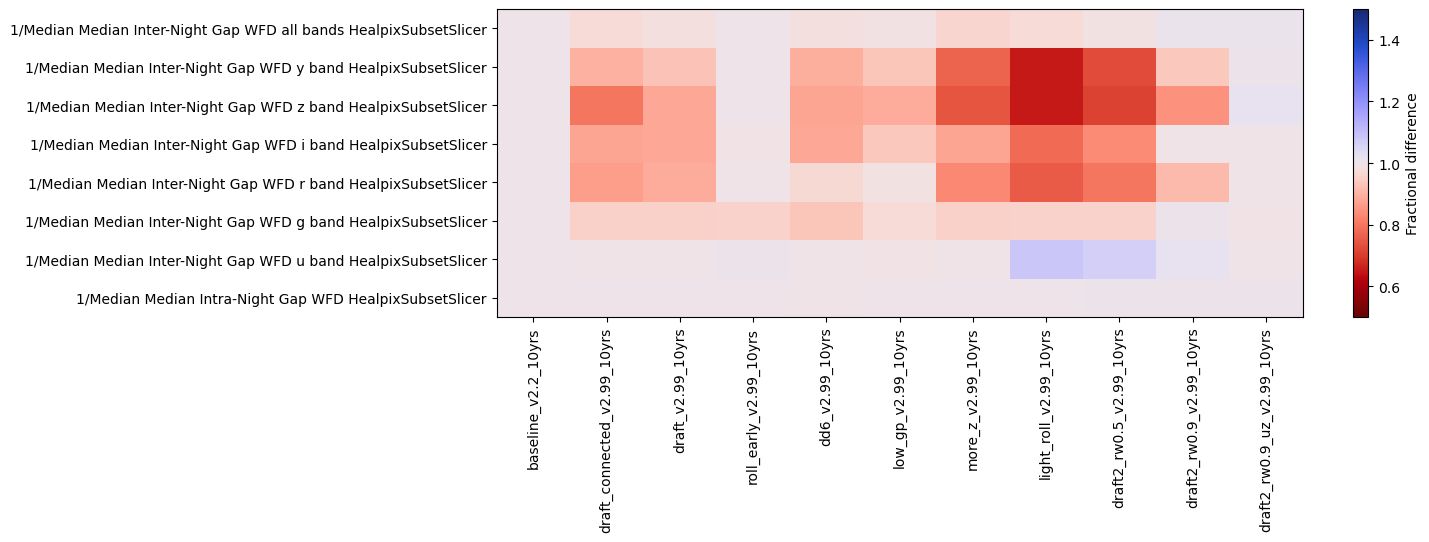

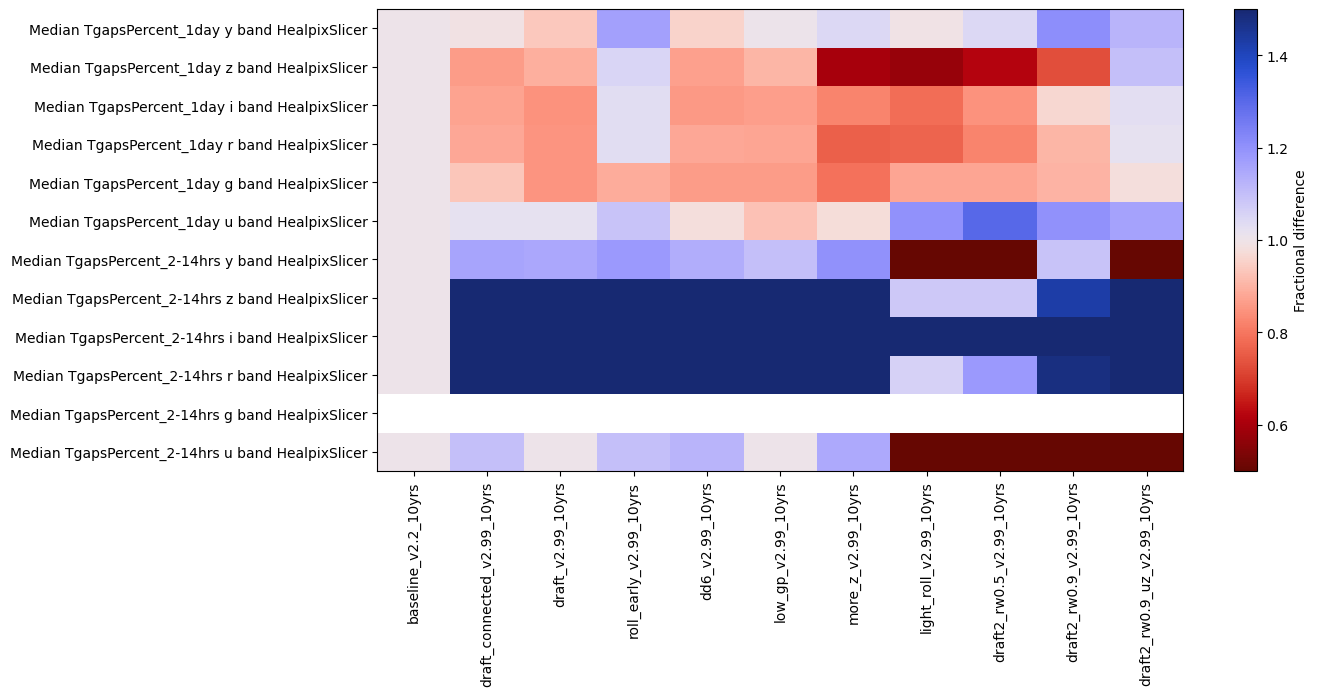

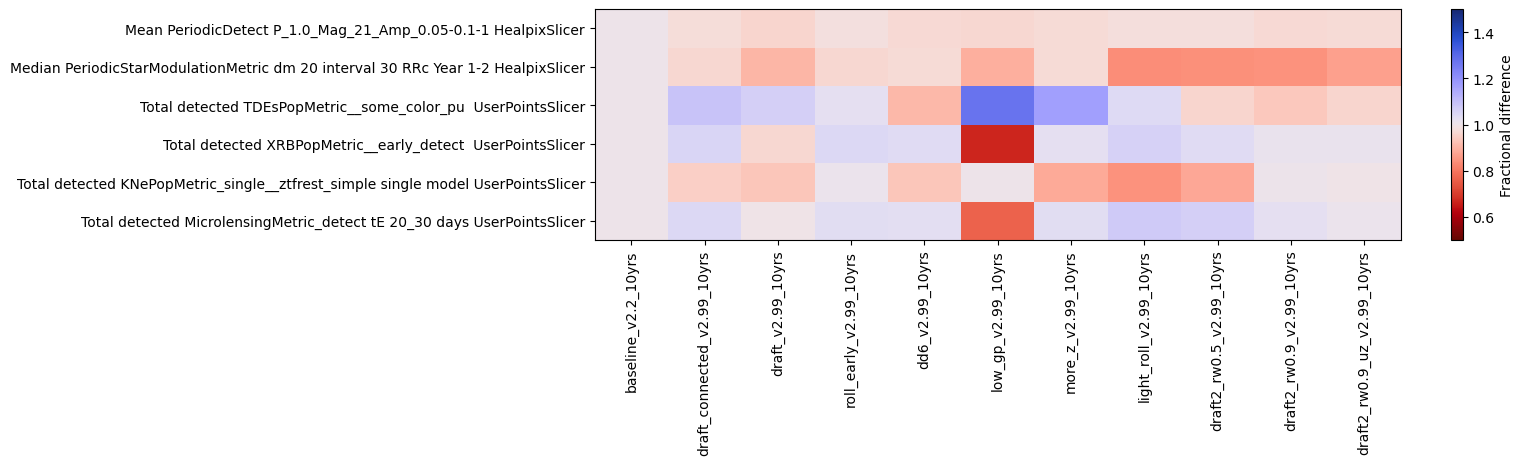

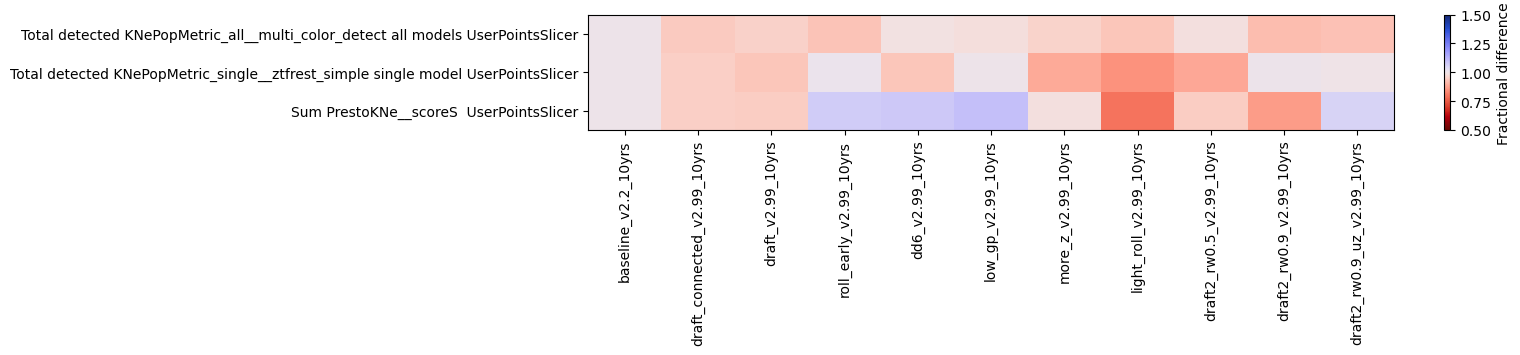

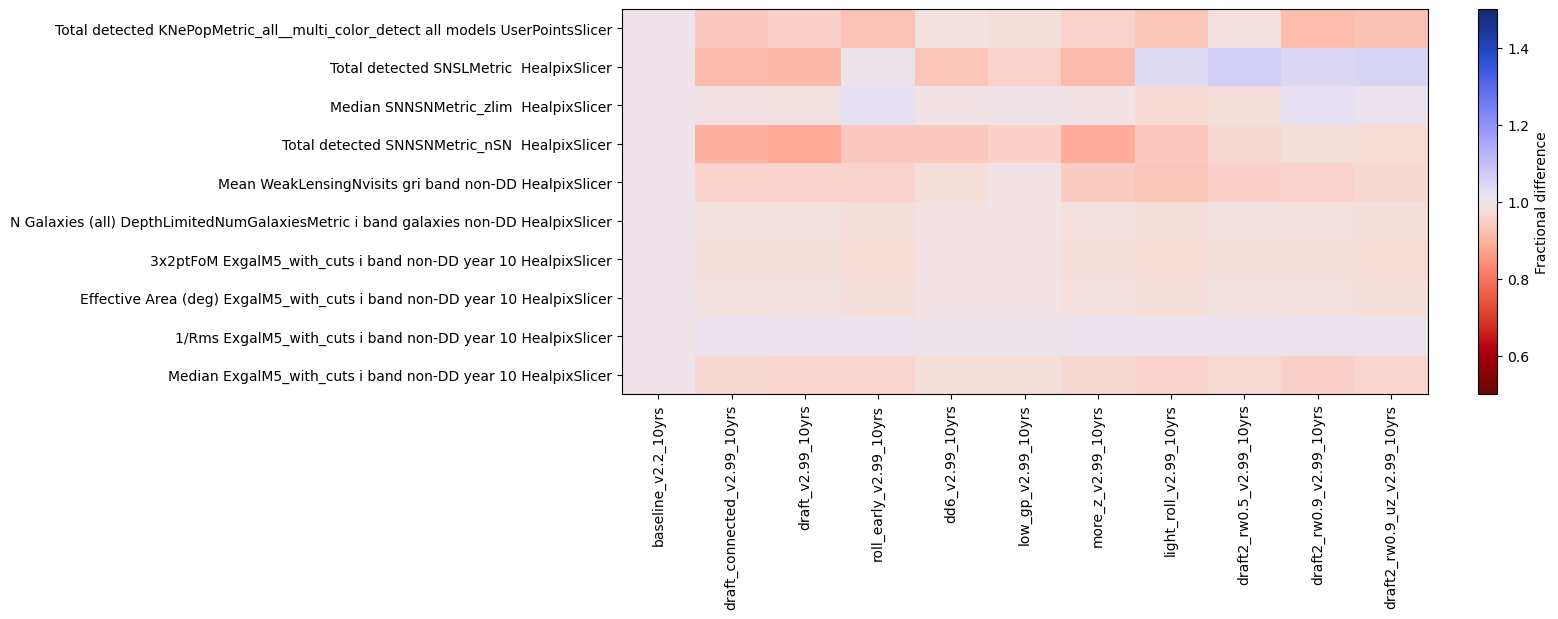

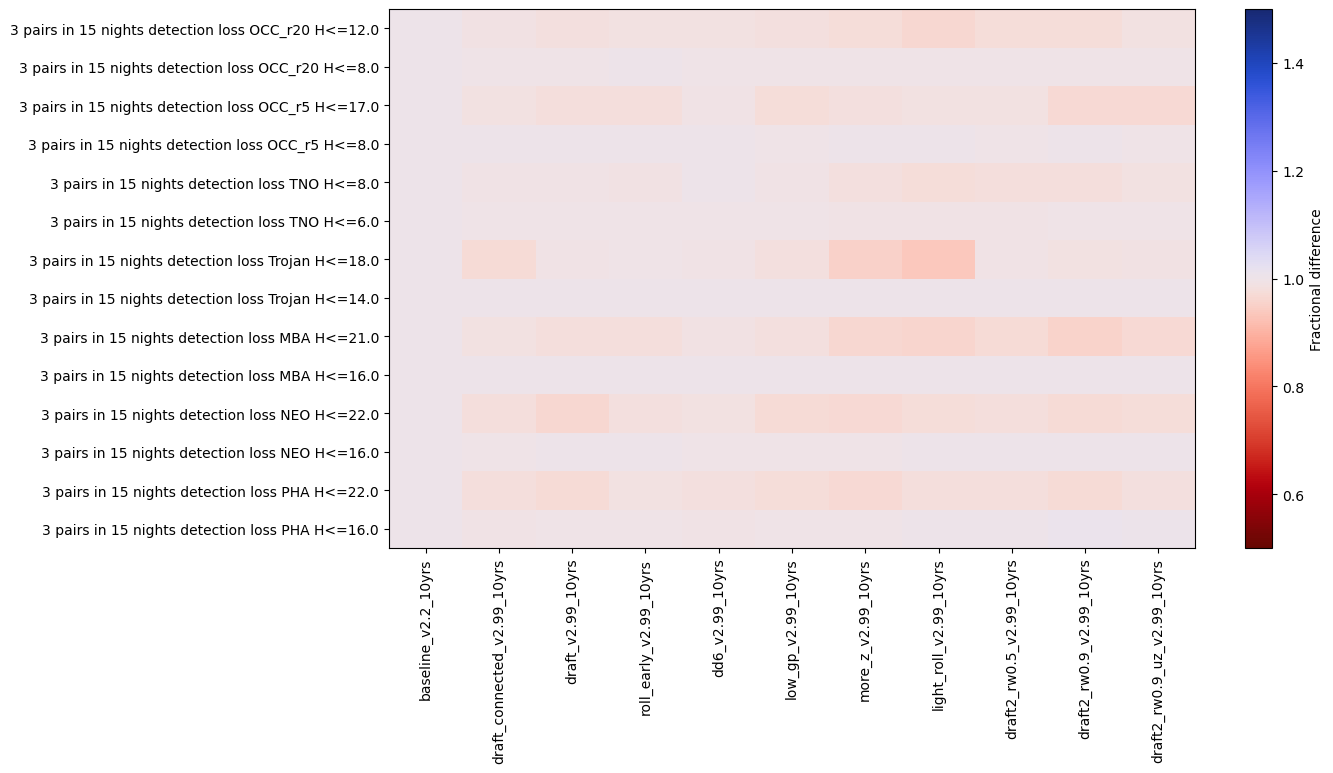

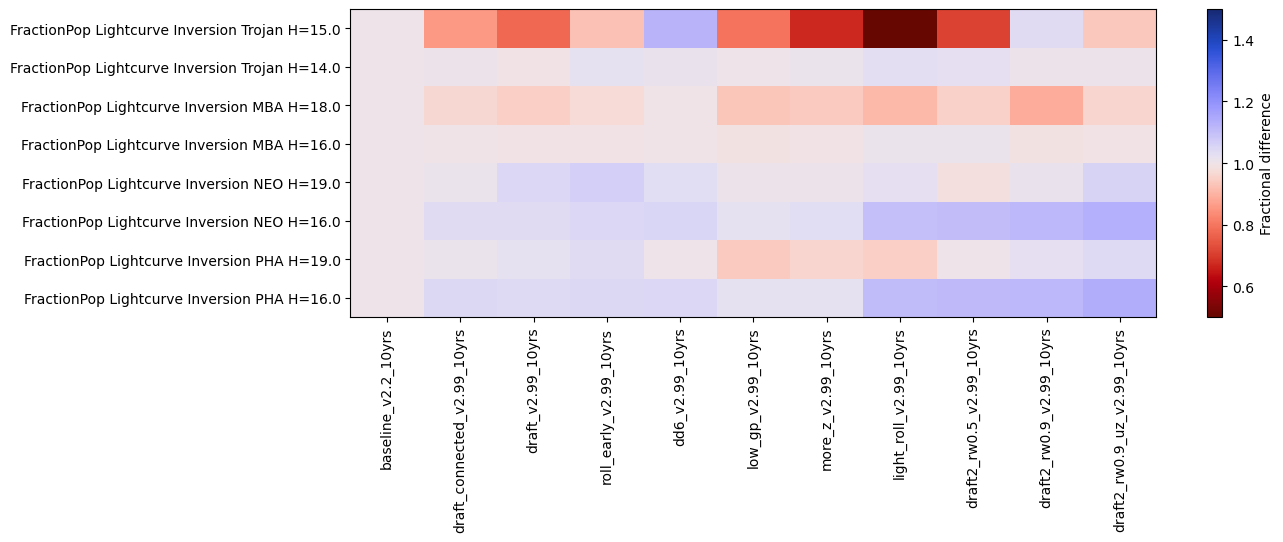

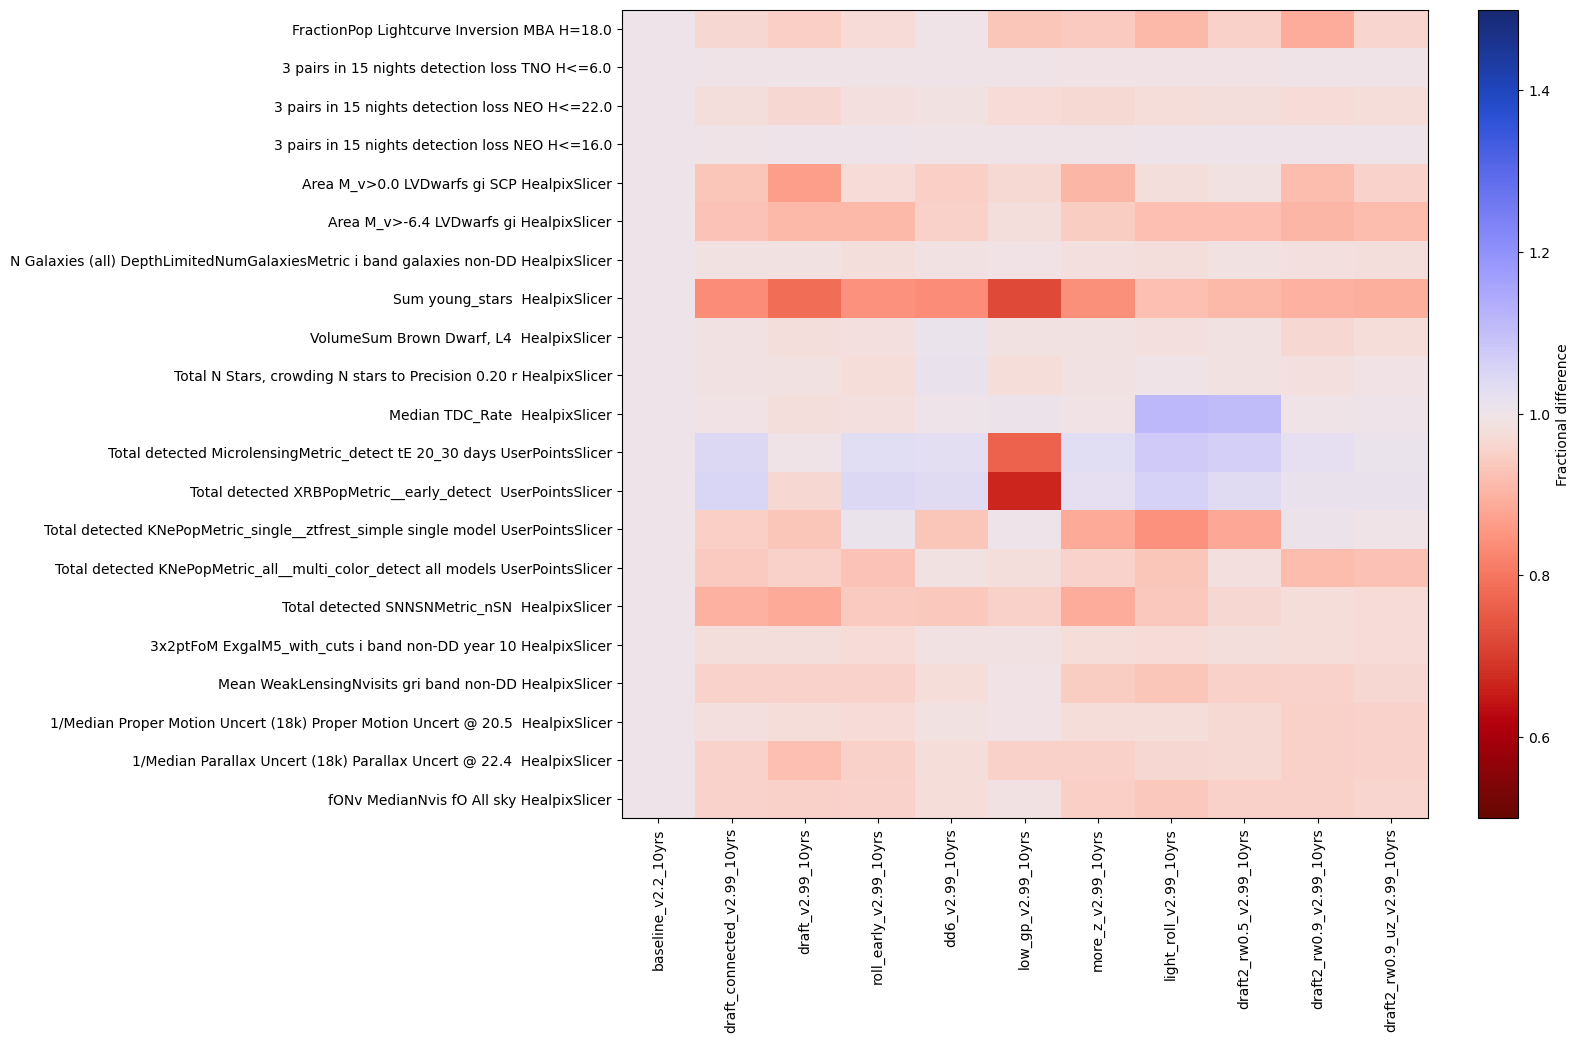

In [157]:
these_runs = list(families.explode('run').loc['draft v3']['run'])
baseline_run = 'baseline_v2.2_10yrs' 
these_runs = [baseline_run] + these_runs

for k in ['SRD', 'WFD Depths', 'cadence', 'TVS Tgaps', 'TVS short', 'TVS KNe short',
      'DESC WFD', 'SSO discovery', 'SSO lightcurve inversion', 'SCOC']:
    msub = metric_sets.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=1)
    fig.set_figwidth(13)
    fig.set_figheight(len(msub)*.5)

In [158]:
pd.DataFrame(summaries.loc[these_runs, 'Nvisits DDF']/summaries.loc[these_runs, 'Nvisits All visits'],
        columns=['Fraction DDF']).round(3)

,Fraction DDF
run,
baseline_v2.2_10yrs,0.050
draft_connected_v2.99_10yrs,0.073
draft_v2.99_10yrs,0.087
roll_early_v2.99_10yrs,0.073
dd6_v2.99_10yrs,0.052
low_gp_v2.99_10yrs,0.072
more_z_v2.99_10yrs,0.080
light_roll_v2.99_10yrs,0.079
draft2_rw0.5_v2.99_10yrs,0.070
